In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 500)
import os
plots_folder = "./plots/mortality"
os.system(f"mkdir -p {plots_folder}")


df_mor=pd.read_csv("https://raw.githubusercontent.com/akarlinsky/world_mortality/main/world_mortality.csv")
df_mor["country_name"] = df_mor["country_name"].apply(lambda x: "Bosnia and Herzegovina" if x == "Bosnia" else x)
df_mor["country_name"] = df_mor["country_name"].apply(lambda x: "Czech Republic" if x == "Czechia" else x)
df_mor["country_name"] = df_mor["country_name"].apply(lambda x: "Macau" if x == "Macao" else x)
df_mor["country_name"] = df_mor["country_name"].apply(lambda x: "Reunion" if x == "Réunion" else x)

In [2]:
df_mor.country_name.unique()

array(['Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bermuda', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Faroe Islands', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Georgia', 'Germany', 'Gibraltar', 'Greece',
       'Greenland', 'Guadeloupe', 'Guatemala', 'Hong Kong', 'Hungary',
       'Iceland', 'Iran', 'Ireland', 'Israel', 'Italy', 'Jamaica',
       'Japan', 'Jordan', 'Kazakhstan', 'Kosovo', 'Kuwait', 'Kyrgyzstan',
       'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macau', 'Malaysia', 'Maldives', 'Malta', 'Martinique',
       'Mauritius', 'Mayotte', 'Mexico', 'Moldov

In [3]:
df_mor_baseline = df_mor[df_mor.year < 2020]
df_mor_baseline = df_mor_baseline.groupby(["country_name","time"]).agg(
    mean_deaths=("deaths", "mean"),
    std_deaths=("deaths", "std"),
    var_deaths=("deaths", "var"),
).reset_index()

In [4]:
df_mor_baseline

,country_name,time,mean_deaths,std_deaths,var_deaths
0,Albania,1,2447.8,418.005622,174728.7
1,Albania,2,1975.2,111.960707,12535.2
2,Albania,3,1980.8,123.432978,15235.7
3,Albania,4,1747.6,113.125152,12797.3
4,Albania,5,1698.6,35.913786,1289.8
...,...,...,...,...,...
3509,Uzbekistan,8,12252.8,699.172153,488841.7
3510,Uzbekistan,9,10857.2,214.839940,46156.2
3511,Uzbekistan,10,11917.8,293.722999,86273.2
3512,Uzbekistan,11,12830.4,533.678555,284812.8


In [5]:
df_mor = df_mor.merge(df_mor_baseline, on=["country_name","time"],how="left")
df_mor["excess_deaths"] = df_mor["deaths"] - df_mor["mean_deaths"]
df_mor["excess_deaths_hi"] = df_mor["deaths"] - (df_mor["mean_deaths"] - 1.645 * df_mor["std_deaths"])
df_mor["excess_deaths_lo"] = df_mor["deaths"] - (df_mor["mean_deaths"] + 1.645 * df_mor["std_deaths"])
df_mor["cumulative_excess_deaths"] = df_mor.groupby(['country_name','year'])['excess_deaths'].apply(lambda x: x.cumsum())
df_mor["std_cumulative_excess_deaths"] = df_mor.groupby(['country_name','year'])['var_deaths'].apply(lambda x: np.sqrt(x.cumsum()))
df_mor["cumulative_excess_deaths_hi"] = df_mor["cumulative_excess_deaths"] + 1.645 * df_mor["std_cumulative_excess_deaths"]
df_mor["cumulative_excess_deaths_lo"] = df_mor["cumulative_excess_deaths"] - 1.645 * df_mor["std_cumulative_excess_deaths"]


In [6]:
df_mor[["cumulative_excess_deaths","excess_deaths","var_deaths","std_cumulative_excess_deaths"]]

,cumulative_excess_deaths,excess_deaths,var_deaths,std_cumulative_excess_deaths
0,42.2,42.2,174728.7,418.005622
1,206.0,163.8,12535.2,432.739991
2,276.2,70.2,15235.7,449.999556
3,434.6,158.4,12797.3,464.000970
4,445.0,10.4,1289.8,465.388762
...,...,...,...,...
24335,17540.4,8955.2,488841.7,2150.504011
24336,20139.2,2598.8,46156.2,2161.208852
24337,21922.4,1783.2,86273.2,2181.077005
24338,22073.0,150.6,284812.8,2245.419716


In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [8]:
def plot_mortality(varname: str, country: str):
   
    plt.figure(figsize=(10,5),dpi=100)
    
    years = df_mor[df_mor.country_name==country]["year"].unique()
    years = [y for y in years if y >= 2020]
    i = 0
    for year in years:
        df_plt = df_mor[(df_mor.year==year) & (df_mor.country_name==country)]
        if len(df_plt.index) == 0:
            raise ValueError(f"Wrong country name: {country}")
        x_max = 55
        interval = 2
        if df_plt.time_unit.unique() == "monthly":
            x_max = 13
            interval = 1
        plt.plot(df_plt.time, df_plt[varname], label=year, linewidth=1.8)
        if varname != "deaths":
            plt.fill_between(df_plt.time, 
                             df_plt[varname+"_lo"], 
                             df_plt[varname+"_hi"],
                             alpha=0.1,
                             color=colors[i])
        i+=1
    df_base = df_mor_baseline[df_mor_baseline.country_name==country]
    if varname == "deaths":
        plt.plot(df_base.time, df_base.mean_deaths, label="baseline", 
             linewidth=1.8, color="black",linestyle="dashed")
        plt.fill_between(df_base.time, 
                         df_base.mean_deaths - 1.645*df_base.std_deaths, 
                         df_base.mean_deaths + 1.645*df_base.std_deaths,
                         alpha=0.1,
                         color="black"
                        )
    else:
        plt.axhline(y=0, color='black', linestyle='dashed',linewidth=1.8)
    plt.grid()
    plt.legend()
    label = "Week of the year"
    if x_max < 50:
        label = "Month of the year"
    plt.xlabel(label, fontsize=12)
    plt.title(f"{country} {varname}".replace("_"," "), fontsize=15)
    plt.ylabel("N. deaths", fontsize=12)
    plt.xticks(np.arange(0, x_max ,interval))
    plt.savefig(f"{plots_folder}/{country}_{varname}.png", bbox_inches="tight", facecolor="w")

In [9]:
countries = ["Israel", "Netherlands", "South Korea", "Italy", "United States", "Denmark", "Singapore"]

/tmp/ipykernel_7543/122497709.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,5),dpi=100)


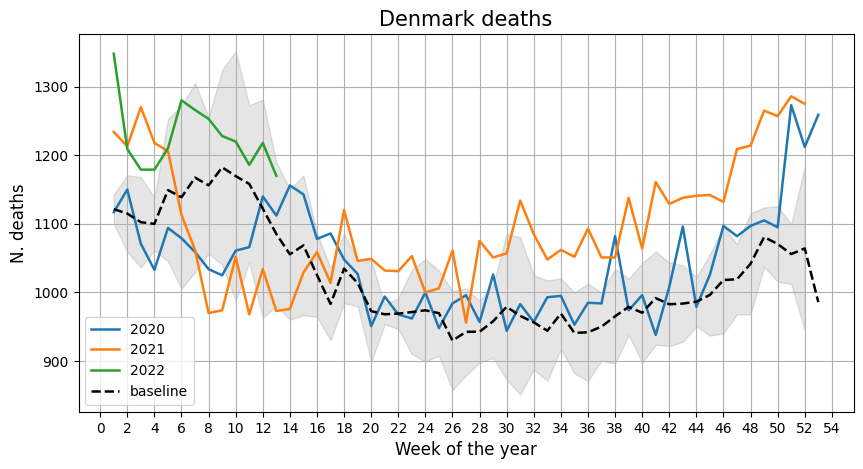

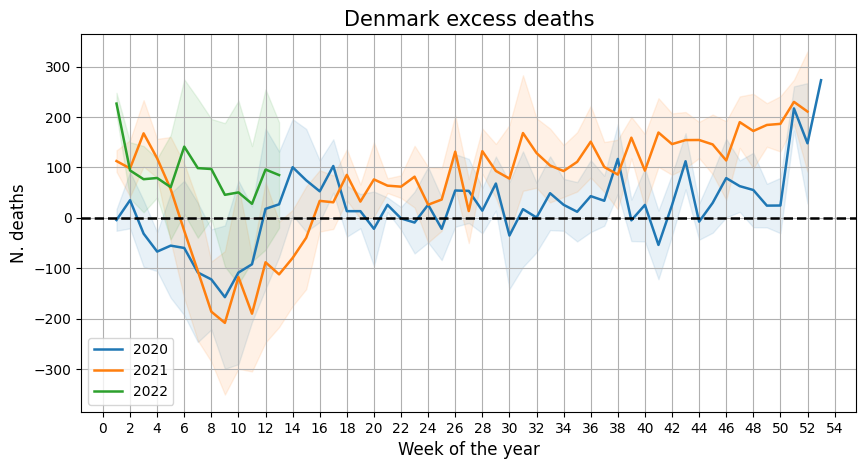

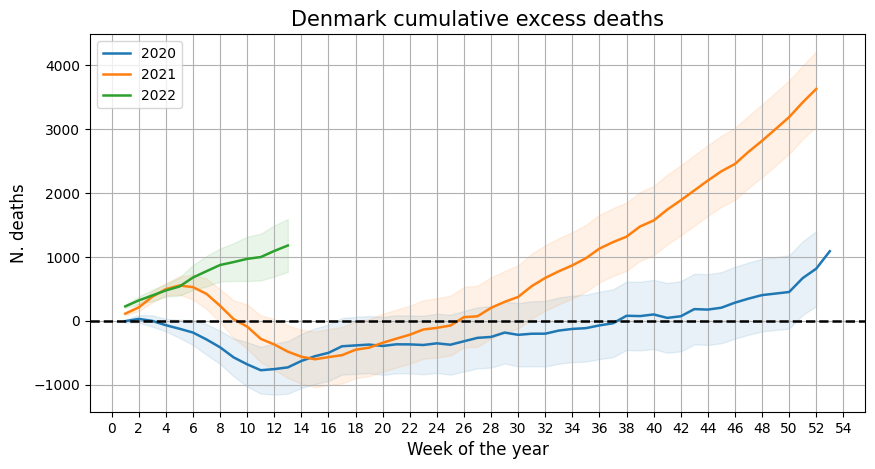

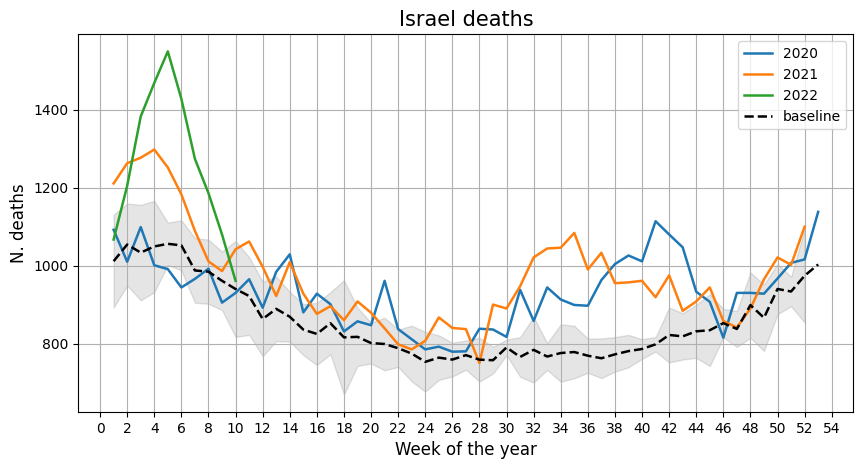

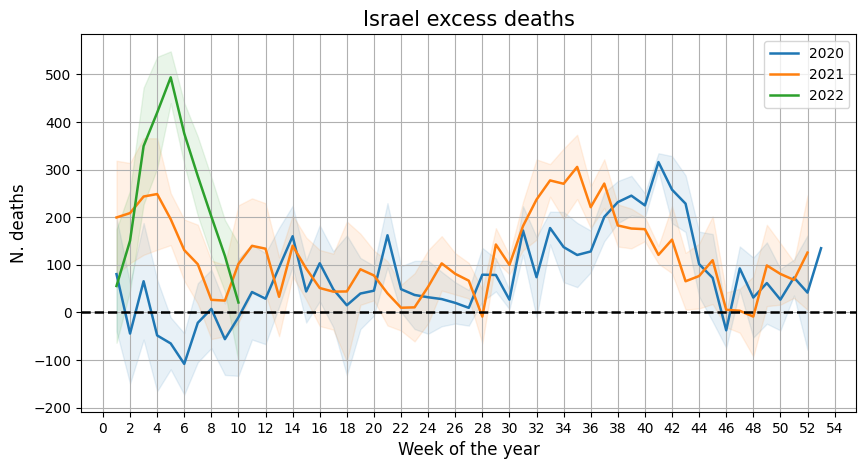

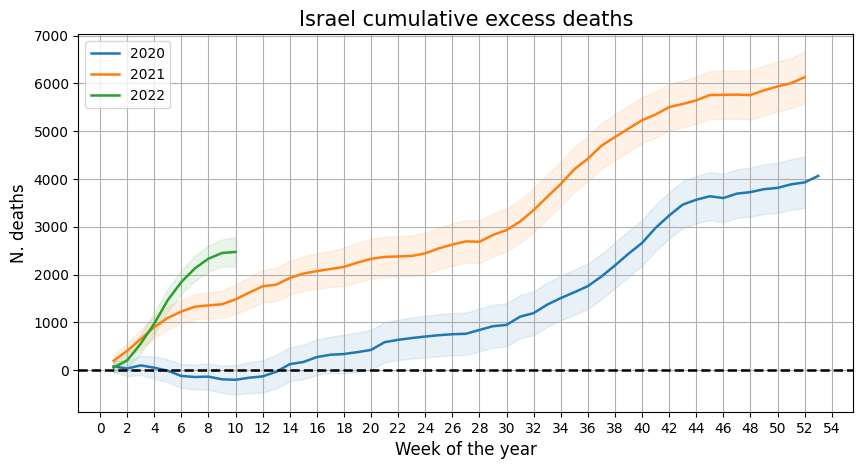

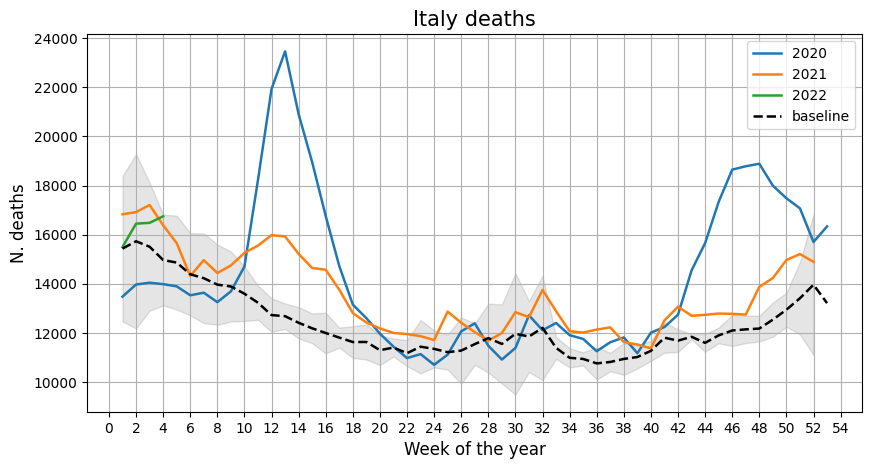

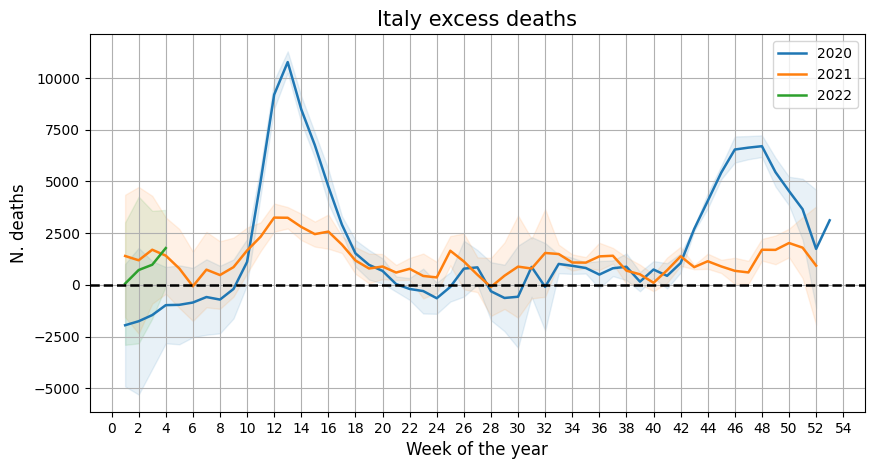

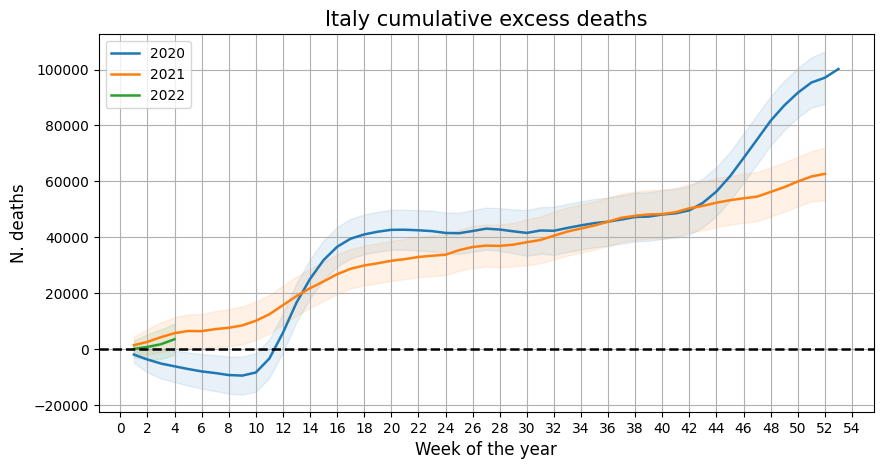

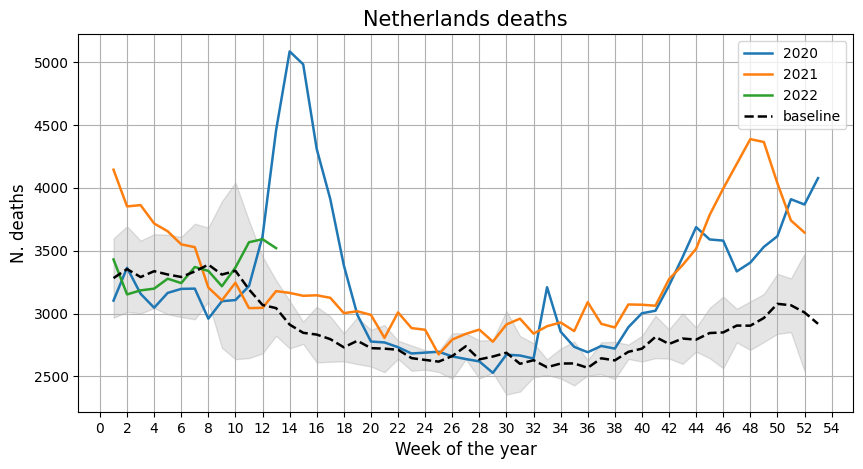

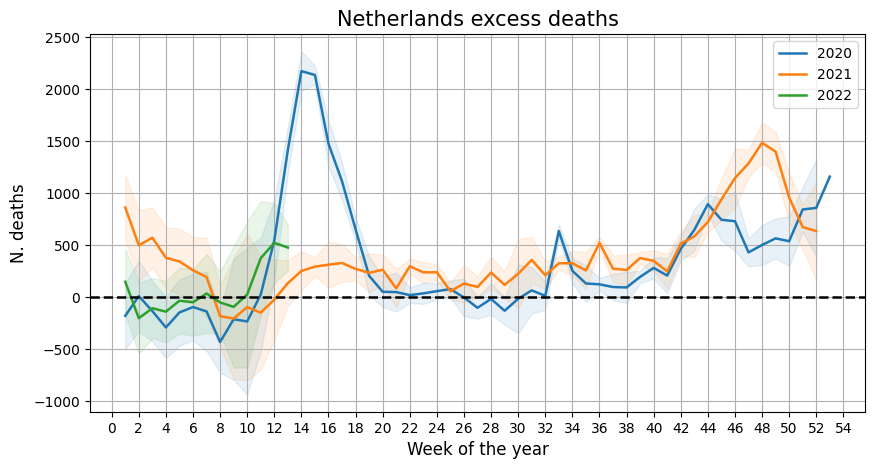

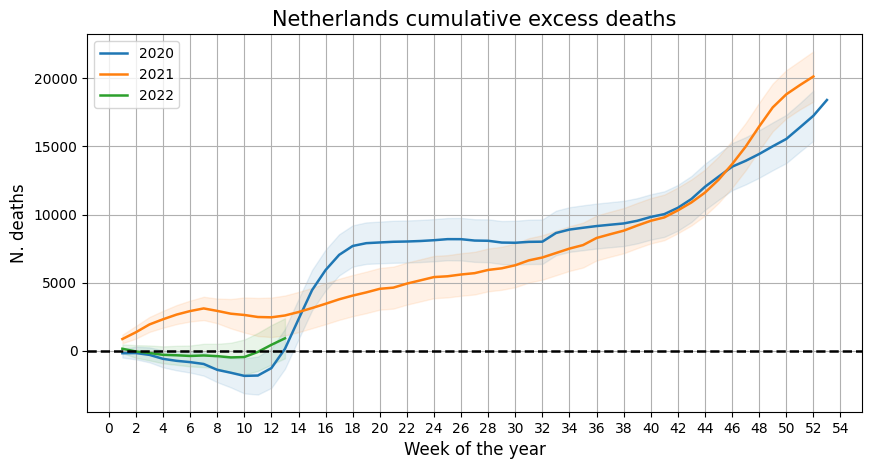

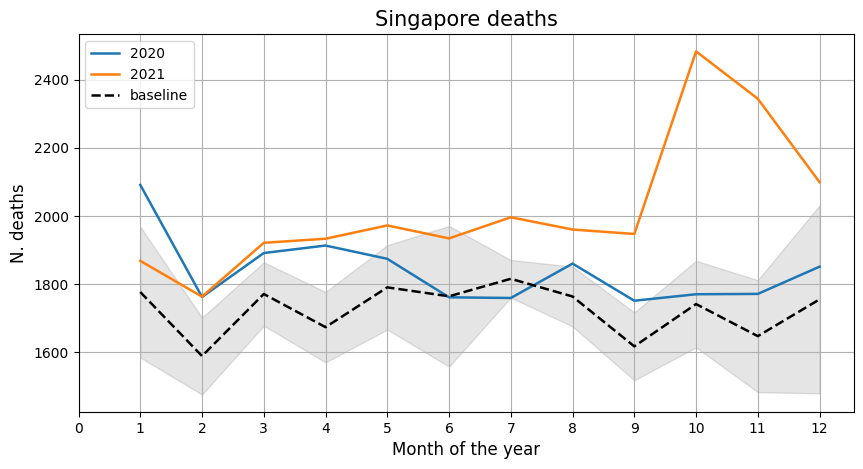

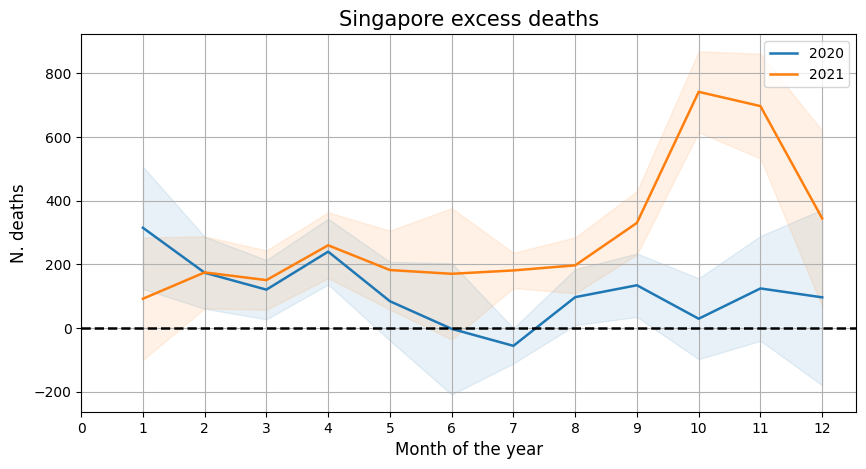

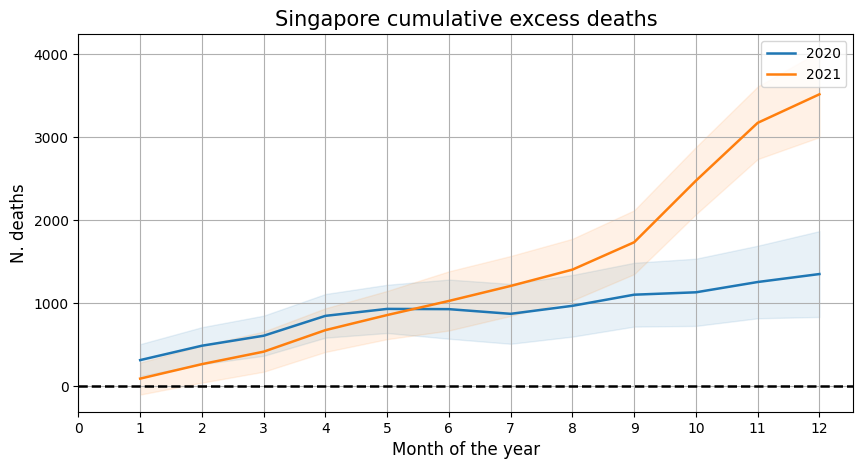

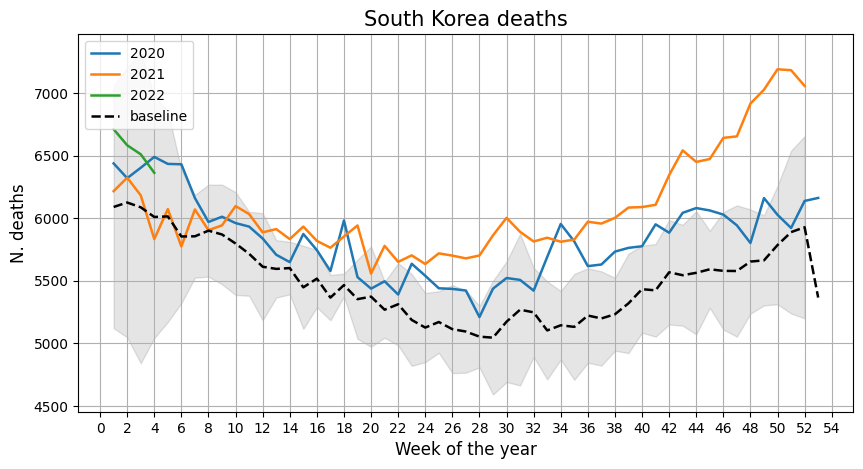

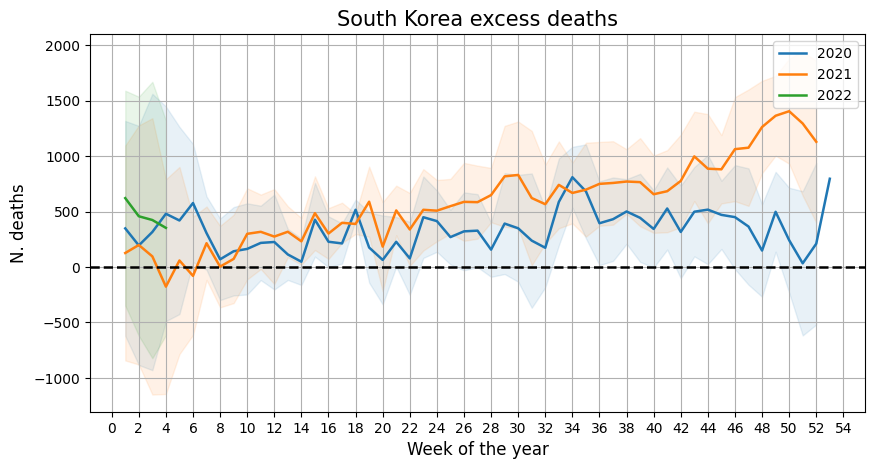

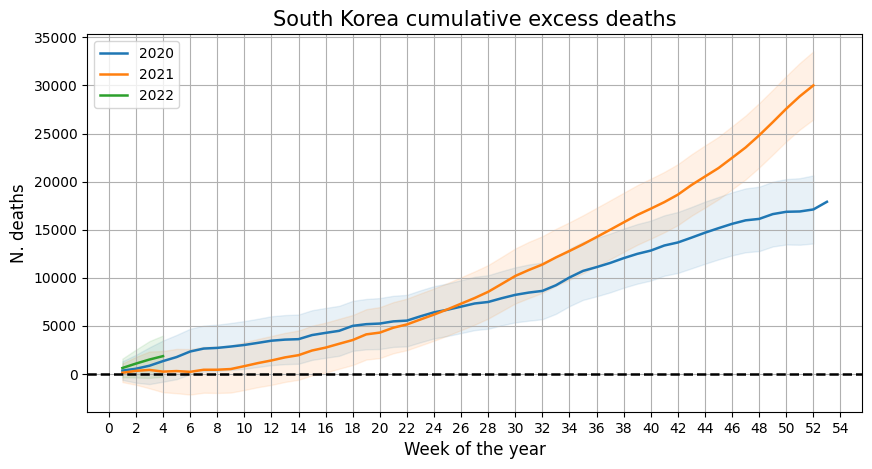

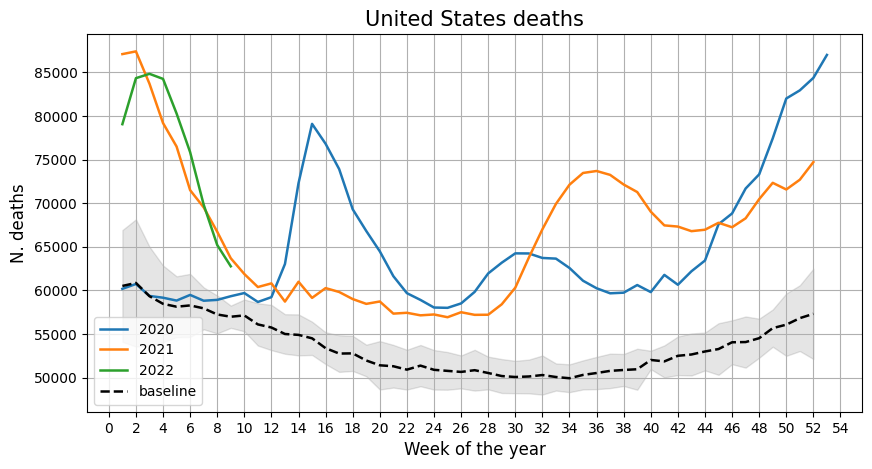

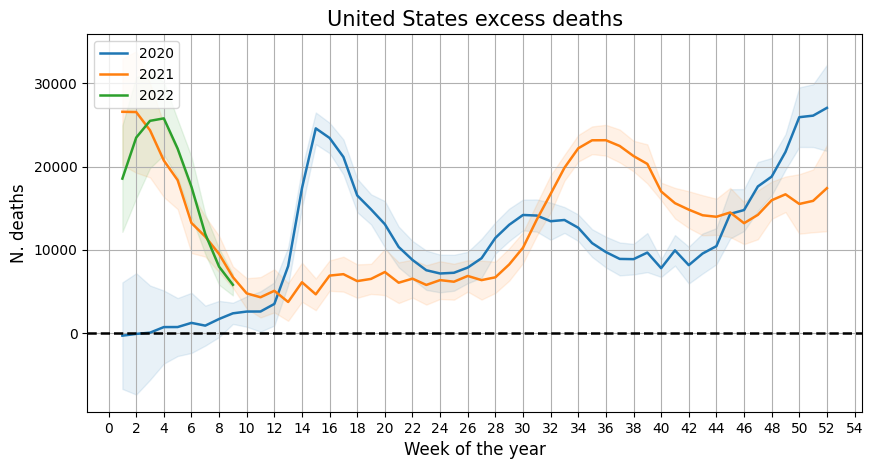

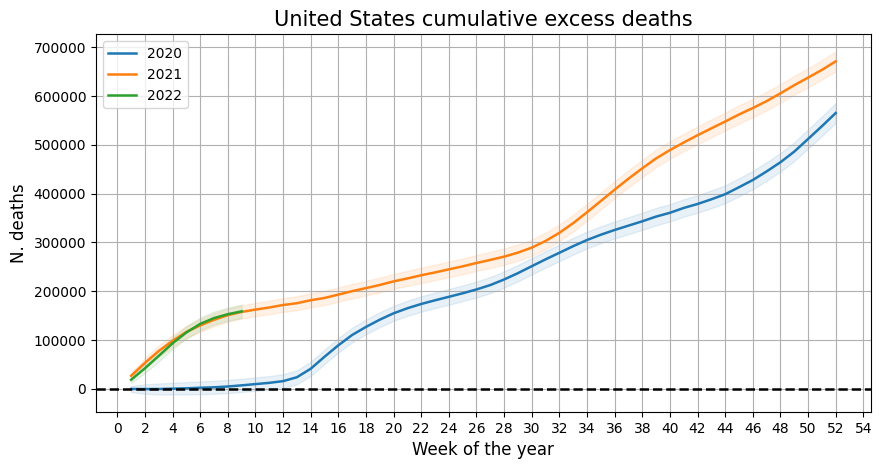

In [10]:
for country in sorted(countries):
    for varname in ["deaths", "excess_deaths", "cumulative_excess_deaths"]:
        plot_mortality(varname=varname, country=country)

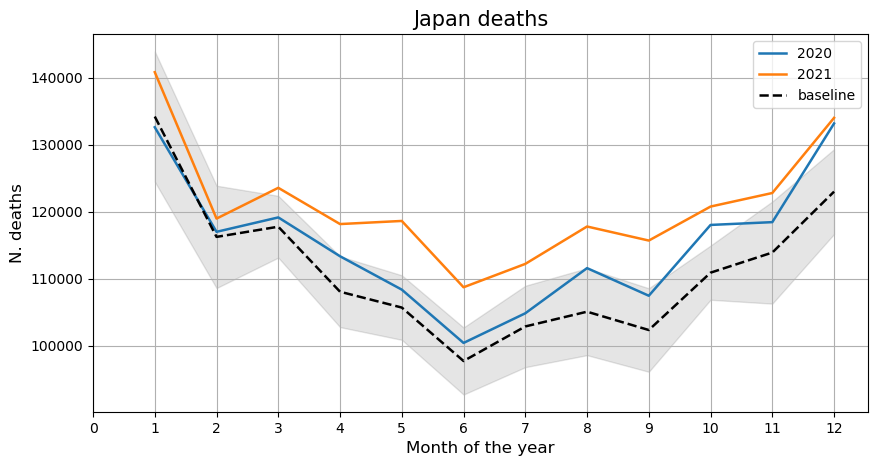

In [28]:
plot_mortality(varname="deaths",
               country="Japan")

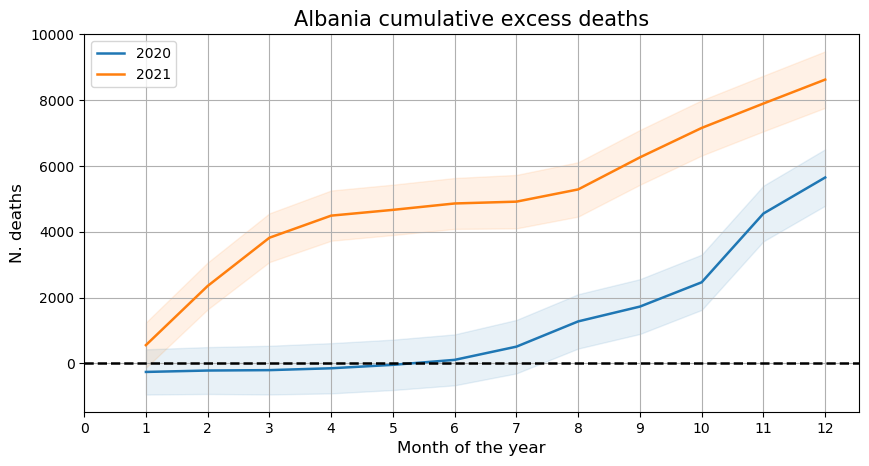

In [29]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Albania")

### Population

In [80]:
df_pop = pd.read_csv("./data/population-by-country.csv")
df_pop = df_pop.rename(columns={"name":"country_name"})[["country_name", "pop2020"]]

In [81]:
df_mor = df_mor.merge(df_pop, on="country_name", how="left")
df_mor["cumulative_excess_deaths_pop"] = df_mor["cumulative_excess_deaths"]/(1000*df_mor["pop2020"])

In [85]:
df_mor

,country_name,year,time,time_unit,deaths,mean_deaths,std_deaths,var_deaths,excess_deaths,excess_deaths_hi,excess_deaths_lo,cumulative_excess_deaths,std_cumulative_excess_deaths,cumulative_excess_deaths_hi,cumulative_excess_deaths_lo,pop2021,pop2020,cumulative_excess_deaths_pop
0,Albania,2015,1,monthly,2490.0,2447.8,418.005622,174728.7,42.2,729.819248,-645.419248,42.2,418.005622,729.819248,-645.419248,2872.933,2877.797,0.000015
1,Albania,2015,2,monthly,2139.0,1975.2,111.960707,12535.2,163.8,347.975364,-20.375364,206.0,432.739991,917.857286,-505.857286,2872.933,2877.797,0.000072
2,Albania,2015,3,monthly,2051.0,1980.8,123.432978,15235.7,70.2,273.247248,-132.847248,276.2,449.999556,1016.449269,-464.049269,2872.933,2877.797,0.000096
3,Albania,2015,4,monthly,1906.0,1747.6,113.125152,12797.3,158.4,344.490875,-27.690875,434.6,464.000970,1197.881595,-328.681595,2872.933,2877.797,0.000151
4,Albania,2015,5,monthly,1709.0,1698.6,35.913786,1289.8,10.4,69.478177,-48.678177,445.0,465.388762,1210.564514,-320.564514,2872.933,2877.797,0.000155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23573,Uzbekistan,2021,8,monthly,21208.0,12252.8,699.172153,488841.7,8955.2,10105.338192,7805.061808,17540.4,2150.504011,21077.979098,14002.820902,33935.763,33469.203,0.000524
23574,Uzbekistan,2021,9,monthly,13456.0,10857.2,214.839940,46156.2,2598.8,2952.211702,2245.388298,20139.2,2161.208852,23694.388561,16584.011439,33935.763,33469.203,0.000602
23575,Uzbekistan,2021,10,monthly,13701.0,11917.8,293.722999,86273.2,1783.2,2266.374333,1300.025667,21922.4,2181.077005,25510.271673,18334.528327,33935.763,33469.203,0.000655
23576,Uzbekistan,2021,11,monthly,12981.0,12830.4,533.678555,284812.8,150.6,1028.501223,-727.301223,22073.0,2245.419716,25766.715432,18379.284568,33935.763,33469.203,0.000660


In [86]:
df_mor[df_mor.country_name=="Italy"][["year","time","country_name","cumulative_excess_deaths_pop"]]

,year,time,country_name,cumulative_excess_deaths_pop
10833,2015,1,Italy,-4.267155e-06
10834,2015,2,Italy,-2.980393e-06
10835,2015,3,Italy,-3.499729e-06
10836,2015,4,Italy,-4.310158e-06
10837,2015,5,Italy,1.677091e-06
10838,2015,6,Italy,2.231491e-05
10839,2015,7,Italy,4.347537e-05
10840,2015,8,Italy,6.298189e-05
10841,2015,9,Italy,7.371593e-05
10842,2015,10,Italy,8.383141e-05


In [48]:
sorted(df_pop.name.unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'DR Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Falkland Islands',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'French Polynesia'